In [42]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_selection import VarianceThreshold

import plotly.express as px


from metaphone import doublemetaphone

# 1) Loading Datasets

In [43]:
movies_df = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t',names=['Wikipedia_ID','Freebase_ID','Name','Release_date','Box_office_revenues','Runtime','Languages','Country','Genres'])
movies_df.head()

,Wikipedia_ID,Freebase_ID,Name,Release_date,Box_office_revenues,Runtime,Languages,Country,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [44]:
character_df = pd.read_csv('MovieSummaries/character.metadata.tsv',sep='\t', names=['Wikipedia_ID','Freebase_ID','Release_date','Character_name','Actor_DOB',
                                                                                    'Sex','Height','Ethnicity','Actor_name','Actor_age','Freebase_character_map'
                                                                                    ,'?','??'])

# 2) Data Cleaning

## 2.a) Cleaning Dictionaries

In [45]:
# Cleaning Languages, Country and Genres Columns

def str_dict_to_values(dict_in_str: str)->list[str]:
    if dict_in_str is None:  
        return []
    dict_ = json.loads(dict_in_str)
    values = list(dict_.values())
    return values

movies_df['Languages'] = movies_df['Languages'].apply(str_dict_to_values)
movies_df['Country'] = movies_df['Country'].apply(str_dict_to_values)
movies_df['Genres'] = movies_df['Genres'].apply(str_dict_to_values)

movies_df.head()

,Wikipedia_ID,Freebase_ID,Name,Release_date,Box_office_revenues,Runtime,Languages,Country,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


## 2.b) Handling NaN values

C:\Users\zacbo\AppData\Local\Temp\ipykernel_10684\3547849048.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\zacbo\AppData\Local\Temp\ipykernel_10684\3547849048.py:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



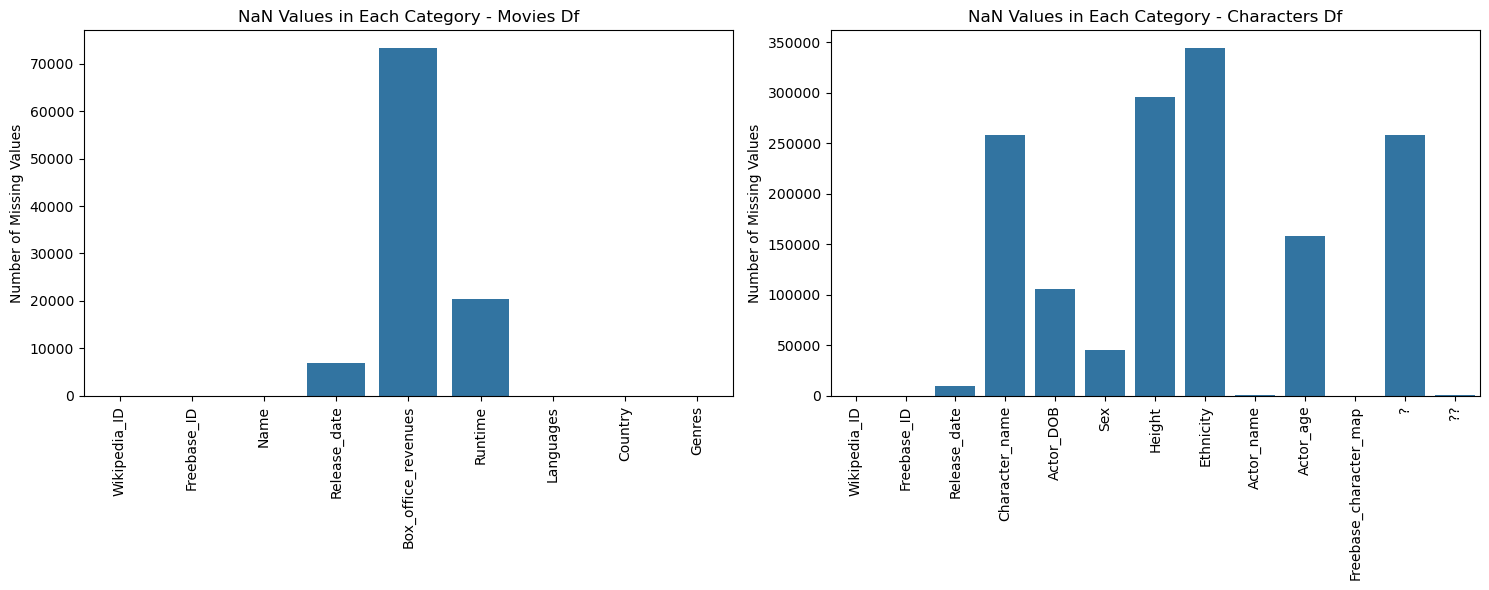

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

missing_values_movies = movies_df.isnull().sum()
missing_values_character = character_df.isnull().sum()

sns.barplot(x=missing_values_movies.index, y=missing_values_movies.values, ax=axs[0])
axs[0].set_xticklabels(missing_values_movies.index, rotation=90)
axs[0].set_xlabel('')
axs[0].set_ylabel('Number of Missing Values')
axs[0].set_title('NaN Values in Each Category - Movies Df')

# Second subplot (could be modified if you want to show different data or style)
sns.barplot(x=missing_values_character.index, y=missing_values_character.values, ax=axs[1])
axs[1].set_xticklabels(missing_values_character.index, rotation=90)
axs[1].set_xlabel('')
axs[1].set_ylabel('Number of Missing Values')
axs[1].set_title('NaN Values in Each Category - Characters Df')

plt.tight_layout()
plt.show()

In [47]:
def remove_nan_rows(df:pd.DataFrame,column:str)->pd.DataFrame:
    no_nan_df = df.dropna(subset=[column])
    return no_nan_df

character_df = remove_nan_rows(character_df,'Character_name')



C:\Users\zacbo\AppData\Local\Temp\ipykernel_10684\3547849048.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\zacbo\AppData\Local\Temp\ipykernel_10684\3547849048.py:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



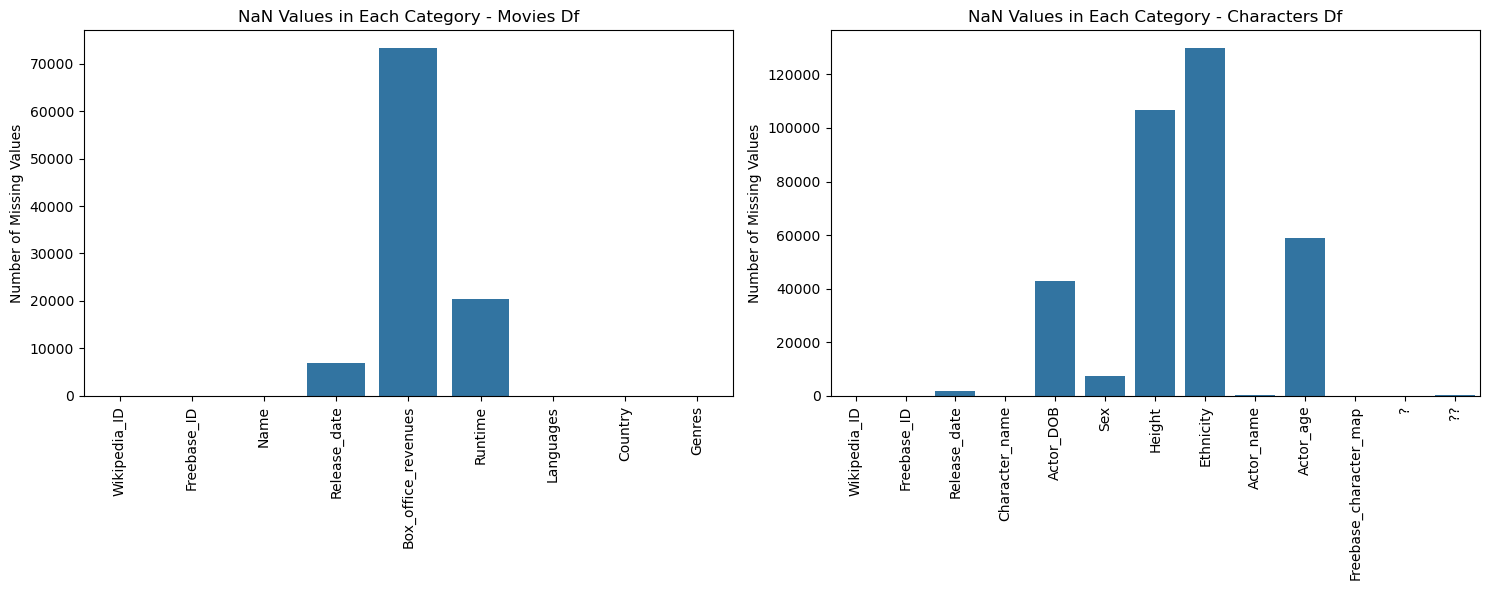

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

missing_values_movies = movies_df.isnull().sum()
missing_values_character = character_df.isnull().sum()

sns.barplot(x=missing_values_movies.index, y=missing_values_movies.values, ax=axs[0])
axs[0].set_xticklabels(missing_values_movies.index, rotation=90)
axs[0].set_xlabel('')
axs[0].set_ylabel('Number of Missing Values')
axs[0].set_title('NaN Values in Each Category - Movies Df')

# Second subplot (could be modified if you want to show different data or style)
sns.barplot(x=missing_values_character.index, y=missing_values_character.values, ax=axs[1])
axs[1].set_xticklabels(missing_values_character.index, rotation=90)
axs[1].set_xlabel('')
axs[1].set_ylabel('Number of Missing Values')
axs[1].set_title('NaN Values in Each Category - Characters Df')

plt.tight_layout()
plt.show()

## 2.c) Common names cleaning

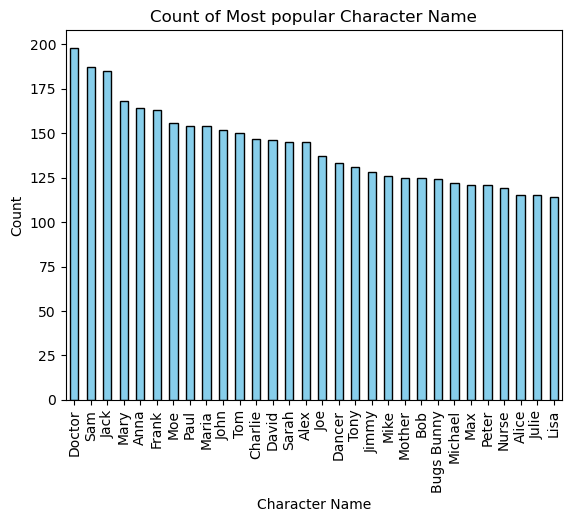

In [49]:
name_counts = character_df['Character_name'].value_counts()

top_names_bar = name_counts.head(30)

top_names_bar.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Character Name')
plt.ylabel('Count')
plt.title('Count of Most popular Character Name')
plt.show()

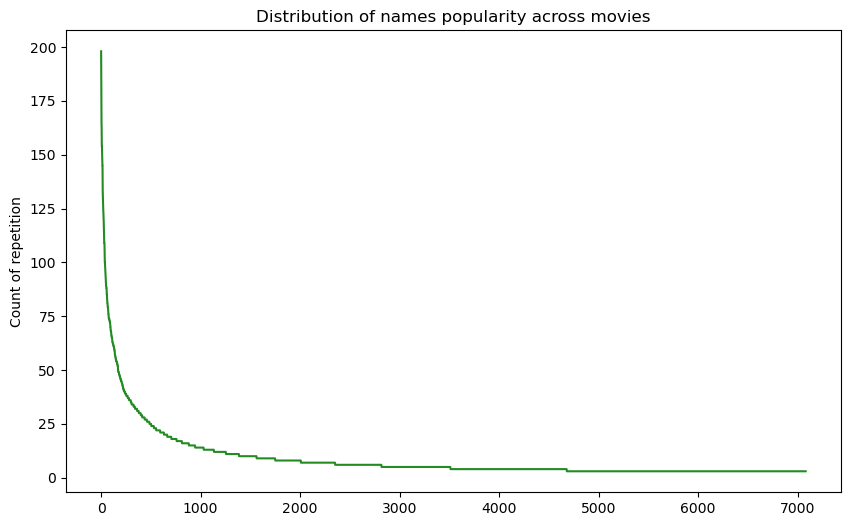

In [50]:
repeated_names = name_counts[name_counts>=3]
plt.figure(figsize=(10, 6))
plt.plot(repeated_names.values, color='forestgreen', linestyle='-', markersize=5)
plt.ylabel("Count of repetition")
plt.title("Distribution of names popularity across movies")
plt.show()

In [51]:
import nltk
nltk.download('words')
from nltk.corpus import words

english_words = set(words.words())
invalid_chars = ['-', '/', '.', ',',"'", '"', '#',"(",')','0','1','2','3','4','5','6','7','8','9']
invalid_word_list = [
    'american', 'british', 'french', 'italian', 'german', 'spanish', 
    'mexican', 'canadian', 'australian', 'japanese', 'russian', 'chinese', 
    'indian', 'brazilian', 'south korean', 'swedish', 'dutch', 'polish', 
    'irish', 'argentine', 'greek', 'egyptian', 'turkish', 'israeli', 
    'south african', 'nigerian', 'filipino', 'indonesian', 'pakistani', 'thai',
    'european', 'asian', 'african', 'le', 'mom', 'la'
]
vowels = set('aeiouy')
def filter_non_english_names(name):
    words_in_name = name.split()

    filtered_words = [
        word for word in words_in_name 
        if word.lower() not in english_words 
        and word.lower() not in invalid_word_list
        and all(char not in word for char in invalid_chars) 
        and any(char in vowels for char in word.lower())
        and sum(1 for char in word if char.isupper()) <= 1
    ]
    return ' '.join(filtered_words)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\zacbo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [52]:
df_character_filtered = character_df.copy()
print(df_character_filtered['Character_name'].shape)

df_character_filtered['Character_name']=df_character_filtered['Character_name'].apply(filter_non_english_names)
print(df_character_filtered['Character_name'].shape)

(192794,)
(192794,)


In [53]:
# Showing Deleted Names
values_filtered = df_character_filtered['Character_name'].value_counts()
deleted_names = character_df[df_character_filtered['Character_name']==values_filtered.index[0]]
print(deleted_names['Character_name'].value_counts().index[0])

Doctor


In [13]:
kept_names = df_character_filtered[df_character_filtered['Character_name']!=values_filtered.index[0]]
kept_names.head()
print(kept_names['Character_name'].shape)

(137677,)


In [14]:
from nltk.corpus import names

# Download the names dataset (only need to do this once)
nltk.download('names')

# Load all names (both male and female) from nltk
all_names = set(names.words())

# Function to check if the name is a first name (male or female)
def keep_names(name):

    name_parts = name.split()
    filtered_names = [
        name for name in name_parts 
        if name in all_names 
    ]
    return ' '.join(filtered_names)

text = 'Joe Paul Antony Toe Mom La'
result = keep_names(text)
print(result)

Joe Paul Antony La


[nltk_data] Downloading package names to
[nltk_data]     C:\Users\zacbo\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [15]:
deleted_names_filtered = deleted_names.copy()
deleted_names_filtered['Character_name']=deleted_names_filtered['Character_name'].apply(keep_names)
print(deleted_names_filtered['Character_name'].shape)
saved_names = deleted_names_filtered[deleted_names_filtered['Character_name']!='']
print(saved_names.shape)

(55117,)
(22755, 13)


In [16]:
print(kept_names.shape)
kept_names = pd.concat([kept_names, saved_names], ignore_index=True)
print(kept_names.shape)
kept_names.head()


(137677, 13)
(160432, 13)


,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Jericho,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [17]:
def keep_first_name(name):
    names = name.split()
    if (len(names)>1):
        name = names[0]
    else:
        name = name
    return name
    
kept_names['Character_name'] = kept_names['Character_name'].apply(keep_first_name)
kept_names.head()

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Jericho,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [18]:
print(kept_names.shape)

(160432, 13)


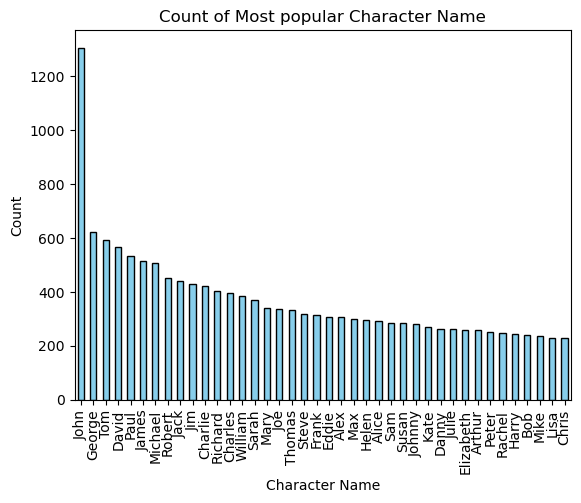

In [19]:
name_counts = kept_names['Character_name'].value_counts()
top_names_bar = name_counts.head(40)
top_names_bar.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Character Name')
plt.ylabel('Count')
plt.title('Count of Most popular Character Name')
plt.show()

# 3) Merging With movie dataset

In [20]:
# Merging the 2 datasets and keeping only interesting features

phonetic_df = pd.merge(movies_df,kept_names, on="Wikipedia_ID",how="inner")[['Wikipedia_ID','Name','Languages','Country','Genres','Character_name','Sex']]

phonetic_df = remove_nan_rows(phonetic_df,'Character_name')
phonetic_df.head()

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex
0,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F
1,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F
2,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M
3,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M
4,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F


In [21]:
kept_names.head()

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Jericho,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


# 4) First Analysis

## 4.a) Genre Analysis

In [22]:
all_genres = phonetic_df['Genres'].explode().dropna().unique()

# Print the unique genres
print(all_genres.shape)

phonetic_df.columns

(338,)


Index(['Wikipedia_ID', 'Name', 'Languages', 'Country', 'Genres',
       'Character_name', 'Sex'],
      dtype='object')

In [23]:
def categorize_genre(genre_list: list) -> list:
    action_adventure = ['Action', 'Adventure', 'Thriller', 'War film', 'Action/Adventure', 'Martial Arts Film', 'Wuxia', 'Superhero movie', 'Western', 'Sword and sorcery', 'Spy', 'Supernatural']
    drama = ['Drama', 'Biographical film', 'Crime Drama', 'Family Film', 'Family Drama', 'Historical fiction', 'Biopic [feature]', 'Courtroom Drama', 'Political drama', 'Family-Oriented Adventure', 'Psychological thriller']
    comedy = ['Comedy', 'Romantic comedy', 'Comedy-drama', 'Comedy film', 'Black comedy', 'Slapstick', 'Romantic comedy', 'Musical', 'Satire', 'Parody', 'Comedy horror']
    horror_thriller = ['Horror', 'Psychological horror', 'Horror Comedy', 'Slasher', 'Thriller', 'Crime Thriller', 'Sci-Fi Horror', 'Suspense', 'Zombie Film', 'Natural horror films']
    fantasy_sci = ['Fantasy', 'Science Fiction', 'Space western', 'Fantasy Adventure', 'Fantasy Comedy', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Fantasy Drama', 'Dystopia', 'Alien Film', 'Cyberpunk', 'Time travel']
    historical_war = ['Historical drama', 'Historical fiction', 'Historical Epic', 'Epic', 'War effort', 'War film', 'Period piece', 'Courtroom Drama']
    romance = ['Romance Film', 'Romantic drama', 'Romance', 'Romantic fantasy', 'Marriage Drama']
    documentary = ['Documentary', 'Docudrama', 'Biography', 'Historical Documentaries', 'Mondo film', 'Patriotic film', 'Educational']
    music_performance = ['Musical', 'Music', 'Musical Drama', 'Musical comedy', 'Dance', 'Jukebox musical', 'Concert film']
    cult_b_movies = ['Cult', 'B-movie', 'Indie', 'Experimental film', 'Surrealism', 'Avant-garde', 'Grindhouse', 'Blaxploitation', 'Camp']

    categories = []

    for genre in genre_list:
        if genre in action_adventure:
            if 'Action & Adventure' not in categories:
                categories.append('Action & Adventure')
        if genre in drama:
            if 'Drama' not in categories:
                categories.append('Drama')
        if genre in comedy:
            if 'Comedy' not in categories:
                categories.append('Comedy')
        if genre in horror_thriller:
            if 'Horror & Thriller' not in categories:
                categories.append('Horror & Thriller')
        if genre in fantasy_sci:
            if 'Fantasy & Sci-Fi' not in categories:
                categories.append('Fantasy & Sci-Fi')
        if genre in historical_war:
            if 'Historical & War' not in categories:
                categories.append('Historical & War')
        if genre in romance:
            if 'Romance' not in categories:
                categories.append('Romance')
        if genre in documentary:
            if 'Documentary' not in categories:
                categories.append('Documentary')
        if genre in music_performance:
            if 'Music & Performance' not in categories:
                categories.append('Music & Performance')
        if genre in cult_b_movies:
            if 'Cult & B-Movies' not in categories:
                categories.append('Cult & B-Movies')

    return categories if categories else ['Other']

In [24]:
# Apply the fct to reduce the numbers of categories
phonetic_df['Genre_Category'] = phonetic_df['Genres'].apply(lambda x: categorize_genre(x))

In [25]:
genres_list = ['Action & Adventure', 'Drama', 'Comedy', 'Horror & Thriller', 
              'Fantasy & Sci-Fi', 'Historical & War', 'Romance', 'Documentary', 
              'Music & Performance', 'Cult & B-Movies', 'Other']

def get_top_names_by_genre(phonetic_df, genres = genres_list):

    df_male = phonetic_df[phonetic_df['Sex'] == 'M']
    df_female = phonetic_df[phonetic_df['Sex'] == 'F']

    top_male_names_by_genre = {}
    top_female_names_by_genre = {}

    # Loop through each genre and get top names for males and females
    for genre in genres:
        male_genre_names = df_male[df_male['Genre_Category'].apply(lambda categories: genre in categories)]

        top_male_names = male_genre_names['Character_name'].value_counts().head(10).index.tolist()
        top_male_names_by_genre[genre] = top_male_names

        female_genre_names = df_female[df_female['Genre_Category'].apply(lambda categories: genre in categories)]

        top_female_names = female_genre_names['Character_name'].value_counts().head(10).index.tolist()
        top_female_names_by_genre[genre] = top_female_names
    
    # Convert dictionaries to DataFrames with each genre as a column
    frequent_names_m = pd.DataFrame.from_dict(top_male_names_by_genre, orient='index').transpose()
    frequent_names_f = pd.DataFrame.from_dict(top_female_names_by_genre, orient='index').transpose()

    return frequent_names_m, frequent_names_f


frequent_names_m, frequent_names_f = get_top_names_by_genre(phonetic_df)

In [26]:
frequent_names_f.head(10)

,Action & Adventure,Drama,Comedy,Horror & Thriller,Fantasy & Sci-Fi,Historical & War,Romance,Documentary,Music & Performance,Cult & B-Movies,Other
0,Sarah,Sarah,Mary,Sarah,Susan,Elizabeth,Sarah,Elizabeth,Pooja,Mary,Radha
1,Susan,Mary,Sarah,Rachel,Alice,Sarah,Helen,Margaret,Priya,Sarah,Rachel
2,Alice,Helen,Kate,Susan,Sarah,Mary,Elizabeth,Helen,Tina,Helen,Anna
3,Mary,Alice,Julie,Alice,Elizabeth,Anne,Julie,Barbara,Anjali,Kate,Pooja
4,Rachel,Susan,Alice,Karen,Mary,Helen,Mary,Marie,Mary,Rachel,Priya
5,Lisa,Elizabeth,Susan,Helen,Claire,Margaret,Susan,Mary,Julie,Alice,Neha
6,Julie,Kate,Helen,Lisa,Kate,Marie,Kate,Alice,Sonia,Linda,Shanti
7,Kate,Rachel,Elizabeth,Kate,Jane,Alice,Alice,Sarah,Radha,Maggie,Madhu
8,Helen,Julie,Lisa,Elizabeth,Lisa,Charlotte,Marie,Dorothy,Sarah,Lisa,Nisha
9,Elizabeth,Marie,Barbara,Claire,Rachel,Catherine,Maggie,Louise,Anita,Karen,Geeta


In [27]:
frequent_names_m.head(10)

,Action & Adventure,Drama,Comedy,Horror & Thriller,Fantasy & Sci-Fi,Historical & War,Romance,Documentary,Music & Performance,Cult & B-Movies,Other
0,John,John,John,John,John,John,John,John,John,John,John
1,Tom,David,George,Michael,George,William,Paul,George,George,Jack,George
2,James,George,Tom,David,David,George,David,Robert,Paul,Tom,Christmas
3,David,Tom,Paul,Tom,Tom,Robert,George,William,Vijay,David,Mickey
4,George,Paul,Charlie,Paul,James,Charles,Tom,Charles,Joe,George,James
5,Michael,James,Jack,James,Michael,James,Michael,David,Shekhar,Paul,Richard
6,Robert,Michael,Michael,Robert,Robert,Thomas,Richard,Richard,Charlie,Michael,Philip
7,William,Robert,David,George,Charlie,David,Robert,James,Johnny,Jim,Tom
8,Jim,Charles,Moe,Jack,Jack,Richard,Charlie,Paul,Rahul,Charlie,Vijay
9,Paul,Jack,Joe,Richard,William,Tom,James,Tom,David,James,Max


In [28]:
def count_name_appearance_by_genre(df, genres=genres_list, name='Tom'):
    # Filter the DataFrame for the specified name
    df_name = df[df['Character_name'] == name]

    # Initialize genre counts dictionary
    genre_counts = {genre: 0 for genre in genres}

    # Count occurrences by genre
    for _, row in df_name.iterrows():
        row_genres = row['Genre_Category']
        if isinstance(row_genres, list):
            for genre in row_genres:
                if genre in genre_counts:
                    genre_counts[genre] += 1
        else:
            if row_genres in genre_counts:
                genre_counts[row_genres] += 1

    # Convert genre counts to DataFrame
    genre_counts_df = pd.DataFrame([genre_counts])

    return genre_counts_df, df_name

# Example usage
genre_counts_result, movies_with_name = count_name_appearance_by_genre(phonetic_df, genres_list, 'Leo')
print(genre_counts_result.head())
movies_with_name.head(10)

   Action & Adventure  Drama  Comedy  Horror & Thriller  Fantasy & Sci-Fi  \
0                  57     75      46                 39                16   

   Historical & War  Romance  Documentary  Music & Performance  \
0                14       27            5                    4   

   Cult & B-Movies  Other  
0               18      1  


,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Genre_Category
545,21271533,Bleeder,[Danish Language],[Denmark],"[Thriller, Drama]",Leo,M,"[Action & Adventure, Horror & Thriller, Drama]"
573,17379289,Without Warning,[English Language],[United States of America],"[Science Fiction, Horror]",Leo,M,"[Fantasy & Sci-Fi, Horror & Thriller]"
2326,13934307,Mammoth,"[Tagalog language, English Language, Thai Lang...","[Denmark, Sweden, Germany]","[Drama, Indie, World cinema]",Leo,M,"[Drama, Cult & B-Movies]"
5938,277710,Heartbreakers,"[Russian Language, English Language]",[United States of America],"[Crime Fiction, Romantic comedy, Romance Film,...",Leo,M,"[Comedy, Romance]"
6918,21845518,Seis días en la oscuridad,[Spanish Language],[Mexico],"[Thriller, Crime Fiction, Drama]",Leo,M,"[Action & Adventure, Horror & Thriller, Drama]"
8435,26717073,Unknown,"[Arabic Language, German Language, English Lan...","[United States of America, Canada, France, Jap...","[Thriller, Mystery, Action, Drama, Psychologic...",Leo,M,"[Action & Adventure, Horror & Thriller, Drama]"
9580,2728447,Bedrooms and Hallways,[English Language],[United Kingdom],"[LGBT, Romantic drama, Romance Film, Drama, Co...",Leo,M,"[Romance, Drama, Comedy]"
9664,648921,Face/Off,"[Latin Language, English Language]",[United States of America],"[Thriller, Crime Fiction, Tragedy, Chase Movie...",Leo,M,"[Action & Adventure, Horror & Thriller, Fantas..."
10147,22574577,Milarepa,[Italian Language],[Italy],[Drama],Leo,M,[Drama]
10313,13814165,Meet the Spartans,[English Language],"[United States of America, Canada]","[Parody, Period piece, Sword and Sandal, Comed...",Leo,M,"[Comedy, Historical & War, Action & Adventure]"


## 4.b) Gender Analysis

In [29]:
male_count = kept_names[kept_names['Sex'] == 'M'].shape[0]
female_count = kept_names[kept_names['Sex'] == 'F'].shape[0]

print(f"Number of male names: {male_count}")
print(f"Number of female names: {female_count}")

Number of male names: 98027
Number of female names: 56821


In [30]:
def count_vowels(name):
    return sum(1 for char in name.lower() if char in vowels)

consonants = set('bcdfghjklmnpqrstvwxz')
def count_consonants(name):
    return sum(1 for char in name.lower() if char not in vowels)

kept_names['vowel_count'] = kept_names['Character_name'].apply(count_vowels)
kept_names['consonant_count'] = kept_names['Character_name'].apply(count_consonants)

print('Mean number of vowels in name by sex:')
kept_names.groupby('Sex')['vowel_count'].agg(['mean', 'std'])

Mean number of vowels in name by sex:


,mean,std
Sex,,
F,2.633991,0.827407
M,2.305355,0.890816


In [31]:
print('Mean number of consonants in name by sex:')
kept_names.groupby('Sex')['consonant_count'].agg(['mean', 'std'])

Mean number of consonants in name by sex:


,mean,std
Sex,,
F,3.241706,1.241886
M,3.547329,1.340265


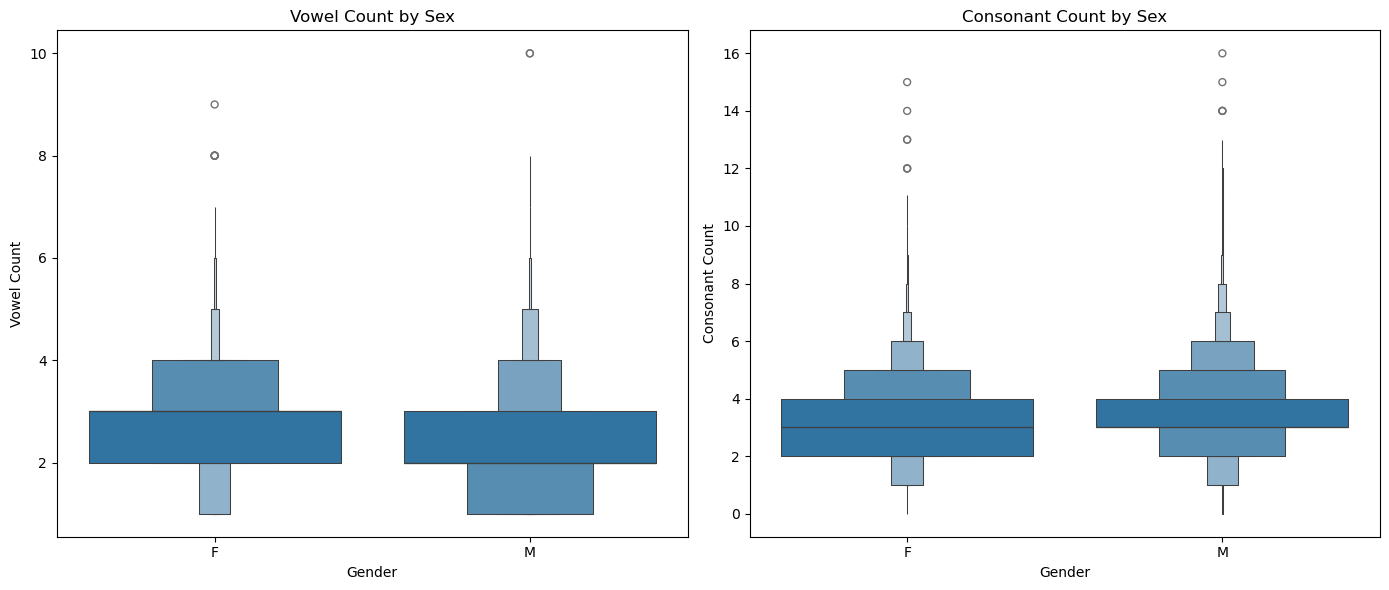

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for vowel count by sex
sns.boxenplot(data=kept_names, x='Sex', y='vowel_count', ax=axes[0])
axes[0].set_title('Vowel Count by Sex')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Vowel Count')

# Boxplot for consonant count by sex
sns.boxenplot(data=kept_names, x='Sex', y='consonant_count', ax=axes[1])
axes[1].set_title('Consonant Count by Sex')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Consonant Count')

# Display the plot
plt.tight_layout()

##### In terms of number of lenght of the names

In [33]:
kept_names['name_length'] = kept_names['Character_name'].apply(lambda name: len(name))
kept_names.groupby('Sex')['name_length'].agg(['mean', 'std'])


,mean,std
Sex,,
F,5.875697,1.671052
M,5.852683,1.853283


In [34]:
kept_names['vowel_percentage'] = kept_names['vowel_count'] / kept_names['name_length']
kept_names['consonant_percentage'] = kept_names['consonant_count'] / kept_names['name_length']

kept_names.groupby('Sex')['vowel_percentage'].agg(['mean', 'std'])

,mean,std
Sex,,
F,0.455882,0.107836
M,0.398126,0.109995


In [35]:
#Regardons pour hommes et femmes séparémeent
kept_names['first_letter'] = kept_names['Character_name'].apply(lambda name: name[0].lower())
first_letter_counts_H = kept_names[kept_names['Sex'] == 'M']['first_letter'].value_counts()
first_letter_counts_F = kept_names[kept_names['Sex'] == 'F']['first_letter'].value_counts()

first_letter_counts_H_percentage = first_letter_counts_H/male_count
first_letter_counts_F_percentage = first_letter_counts_F/female_count

#Let's merge the two series
first_letter_counts = pd.concat([first_letter_counts_H_percentage, first_letter_counts_F_percentage], axis=1)
first_letter_counts = first_letter_counts.head(26)
first_letter_counts.columns = ['first_letter_men', 'first_letter_women']

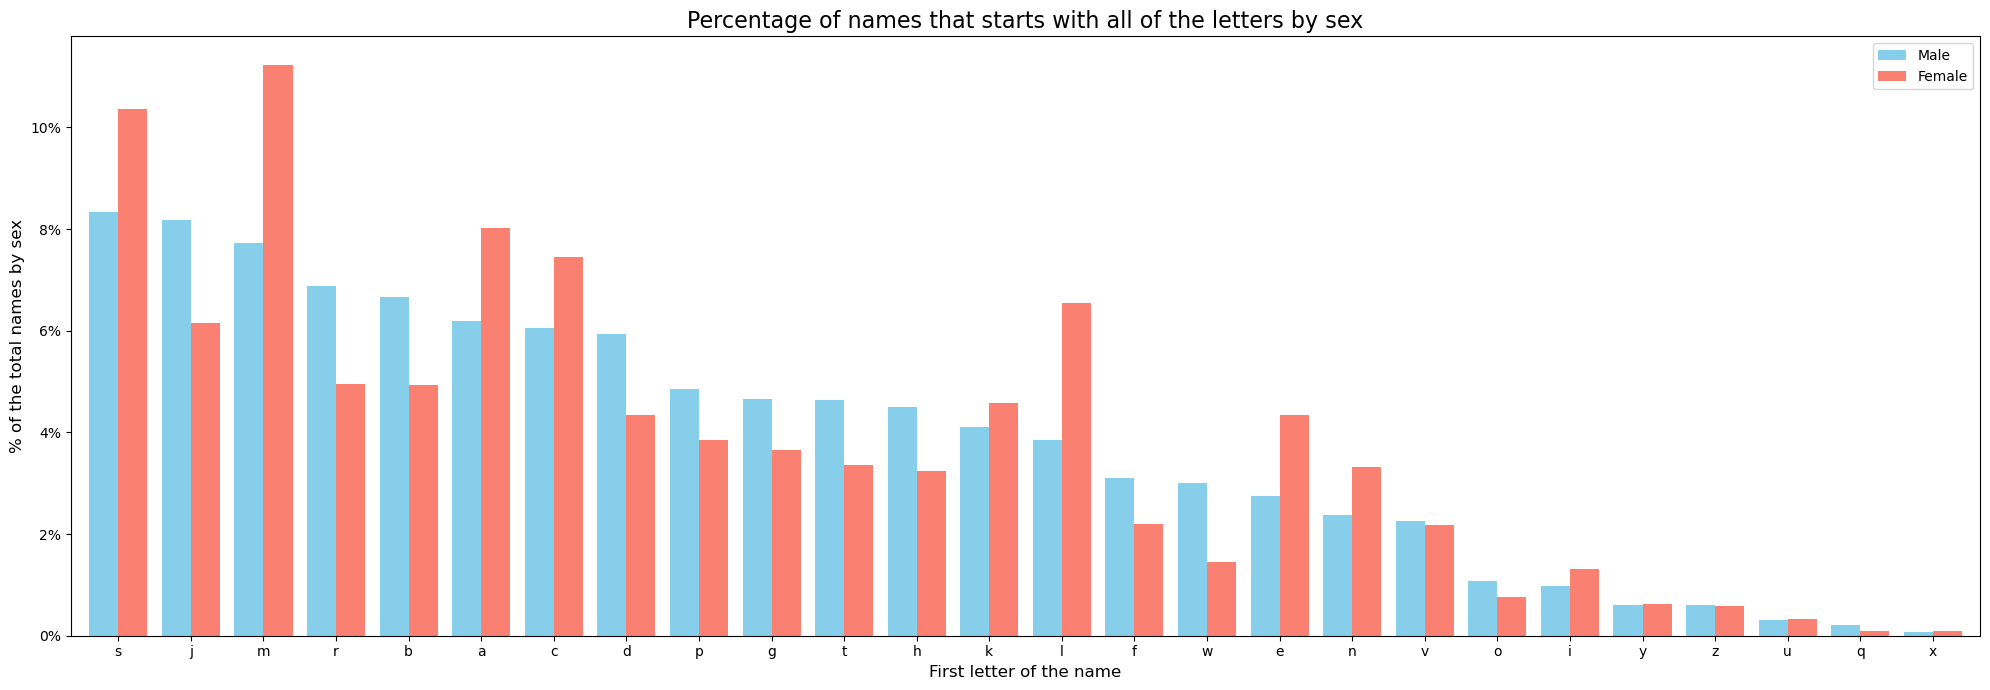

In [36]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(20, 7))

first_letter_counts.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

ax.set_title('Percentage of names that starts with all of the letters by sex', fontsize=16)
ax.set_xlabel('First letter of the name', fontsize=12)
ax.set_ylabel('% of the total names by sex', fontsize=12)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

ax.legend(['Male', 'Female'])

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [37]:
# Analyze the last letter of each name for men and women separately
kept_names['last_letter'] = kept_names['Character_name'].apply(lambda name: name[-1].lower())
last_letter_counts_H = kept_names[kept_names['Sex'] == 'M']['last_letter'].value_counts()
last_letter_counts_F = kept_names[kept_names['Sex'] == 'F']['last_letter'].value_counts()

last_letter_counts_H_percentage = last_letter_counts_H/male_count
last_letter_counts_F_percentage = last_letter_counts_F/female_count

# Merge the two series
last_letter_counts = pd.concat([last_letter_counts_H_percentage, last_letter_counts_F_percentage], axis=1)
last_letter_counts = last_letter_counts.head(26)
last_letter_counts.columns = ['last_letter_men', 'last_letter_women']

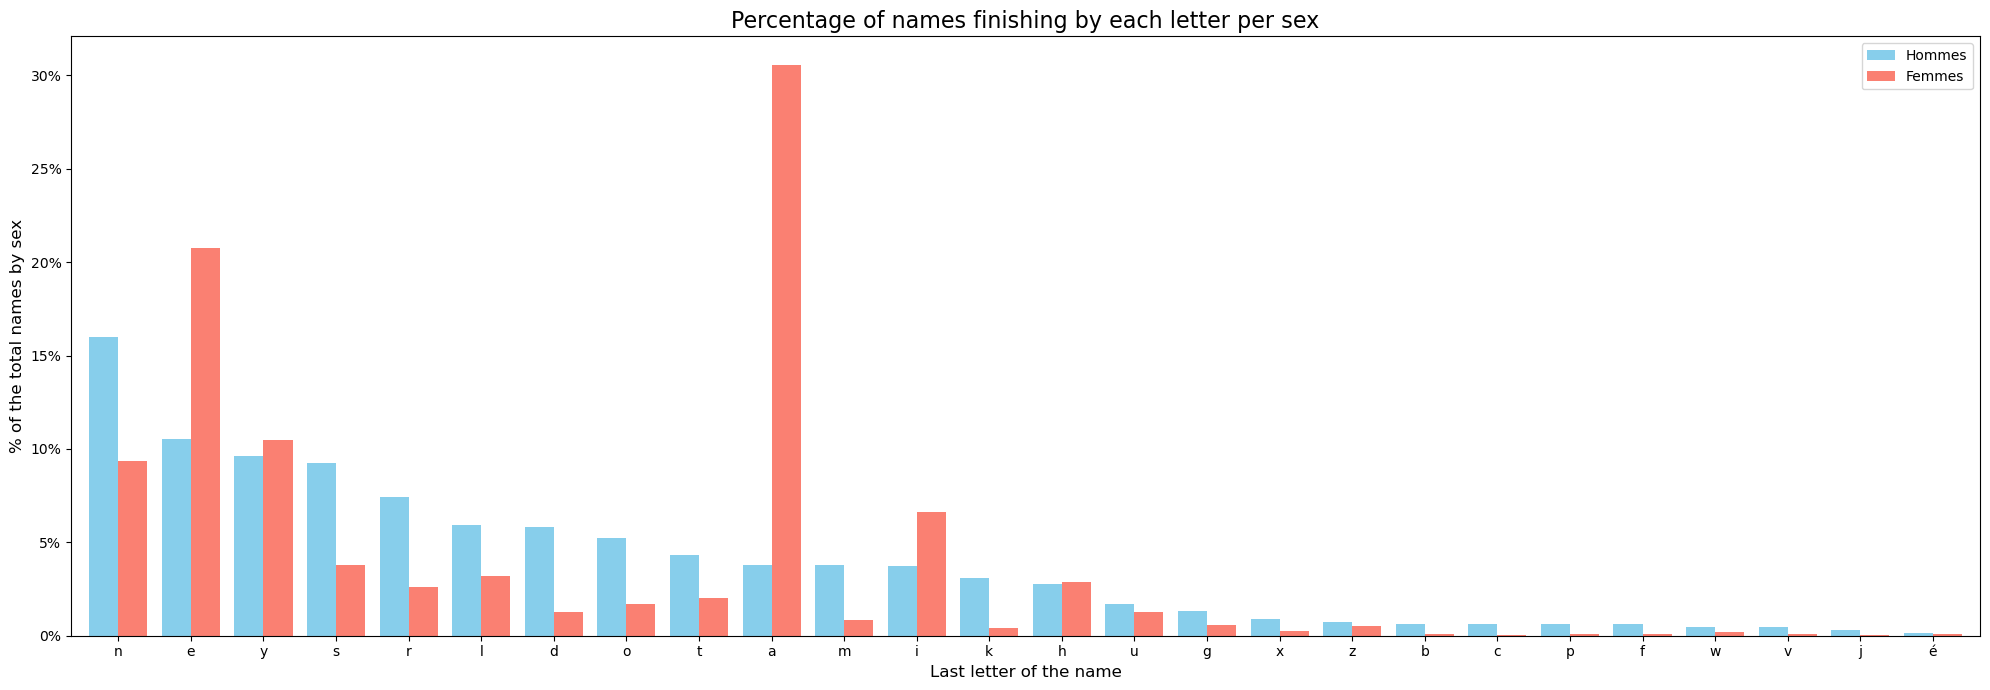

In [38]:
fig, ax = plt.subplots(figsize=(20, 7))

# Tracer les barres pour les hommes et les femmes
last_letter_counts.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

# Ajouter les titres et labels
ax.set_title('Percentage of names finishing by each letter per sex', fontsize=16)
ax.set_xlabel('Last letter of the name', fontsize=12)
ax.set_ylabel('% of the total names by sex', fontsize=12)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
ax.legend(['Hommes', 'Femmes'])

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### Find the top 3 names by sex for each age category

In [39]:
age_bins = [0, 12, 17, 24, 34, 44, 54, 64, 74, 84, 100]
age_labels = [
    '<12y', '13y-17y', '18y-24y', '25y-34y', '35y-44y', 
    '45y-54y', '55y-64y', '65y-74y', '75y-84y', '>85y'
]

kept_names['age_category'] = pd.cut(kept_names['Actor_age'], bins=age_bins, labels=age_labels, right=False)

age_sex_counts = kept_names.groupby(['age_category', 'Sex']).size().unstack(fill_value=0)
total_counts = kept_names['Sex'].value_counts()
age_sex_percentage = age_sex_counts.div(total_counts, axis=1) * 100

top_names = (
    kept_names.groupby(['age_category', 'Sex'])['Character_name']
    .apply(lambda x: x.value_counts().head(3).index.tolist())
    .unstack(fill_value=[])
)

fig = go.Figure()

for sex in ['M', 'F']:
    fig.add_trace(go.Bar(
        x=age_labels,
        y=age_sex_percentage[sex],
        name='Male' if sex == 'M' else 'Female',
        marker_color='skyblue' if sex == 'M' else 'salmon',
        hovertext=[f"Top names: {', '.join(top_names.loc[age, sex])}" for age in age_labels],
        hoverinfo="text"
    ))

fig.update_layout(
    title='Percentage of Males and Females in Each Age Category',
    xaxis_title='Age Category',
    yaxis_title='% of Total Males/Females',
    barmode='group',
    xaxis=dict(tickvals=age_labels, tickangle=0),
    yaxis=dict(ticksuffix='%'),
    legend=dict(title="Sex")
)

fig.show()

C:\Users\zacbo\AppData\Local\Temp\ipykernel_10684\269373721.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_sex_counts = kept_names.groupby(['age_category', 'Sex']).size().unstack(fill_value=0)
C:\Users\zacbo\AppData\Local\Temp\ipykernel_10684\269373721.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kept_names.groupby(['age_category', 'Sex'])['Character_name']


## 4.c) Country Analysis

### 4.c.1) Top names per continent

In [40]:

countries_code = []
def country_to_continent(country_name):
    try:
        # Get the alpha-2 country code
        country_code_alpha2 = pycountry.countries.lookup(country_name).alpha_2
        country_code_alpha3 = pycountry.countries.lookup(country_name).alpha_3
        if country_code_alpha3 not in countries_code:
            countries_code.append(country_code_alpha3)
        continent_code = pc.country_alpha2_to_continent_code(country_code_alpha2)

        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (KeyError, AttributeError, LookupError):
        return None 

In [41]:
phonetic_df['primary_country'] = phonetic_df['Country'].str[0]
phonetic_df['Continent'] = phonetic_df['primary_country'].apply(country_to_continent)
phonetic_df.head(10)

continents = phonetic_df.groupby(['Continent','Sex'])['Character_name'].agg(pd.Series.mode)
df_continents = continents.to_frame().reset_index()
df_continents.columns = ['Continent', 'Sex', 'Name']
df_continents = df_continents.pivot(index='Continent',columns='Sex',values='Name').reset_index()
df_continents.columns = ['Continent', 'Female_name', 'Male_name']
df_continents.head()



NameError: name 'pycountry' is not defined

In [ ]:
# for Africa we will pick one of the names to display

df_continents.loc[0,'Female_name'] = 'Amina*'
df_continents.loc[0,'Male_name']='Omar*'

df_continents.head()

,Continent,Female_name,Male_name
0,Africa,Amina*,Omar*
1,Asia,Priya,Vijay
2,Europe,Anna,John
3,North America,Sarah,John
4,Oceania,Angie,John


In this table we see the most recurrent character names for each continent. For Asia, we see that the most common names are indian names. Is it because other nearby countries are influenced by the bollywood industry or because India's movies are predominent in this dataset? 
We will try to answer the question by plotting the most common character names per country and reting it with the number of movies from this country in the dataset.

### 4.c.2) Top names per country

In [ ]:
country_top_name = phonetic_df.groupby(['primary_country','Sex'])['Character_name'].agg(pd.Series.mode)
df_top_name = country_top_name.to_frame().reset_index()
df_top_name.columns = ['primary_country', 'Sex', 'Name']
df_top_name = df_top_name.pivot(index='primary_country',columns='Sex',values='Name').reset_index()
df_top_name.columns = ['primary_country', 'Female_name', 'Male_name']

def tie_case(name_row):
    if isinstance(name_row,np.ndarray):
        name_row = name_row[0]
    return name_row

df_top_name['Female_name'] = df_top_name['Female_name'].apply(tie_case) #In case of a tie we choose the 1st element
df_top_name['Male_name'] = df_top_name['Male_name'].apply(tie_case) #In case of a tie we choose the 1st element
df_top_name.head()

In [ ]:
phonetic_df['primary_country'] = phonetic_df['Country'].str[0]
phonetic_df['Continent'] = phonetic_df['primary_country'].apply(country_to_continent)
proportion_country = phonetic_df.groupby(['Continent', 'primary_country'])['primary_country'].count()
df_nb_movie = proportion_country.to_frame()
df_nb_movie.columns = ['Number_of_movies']
df_nb_movie = df_nb_movie.reset_index()
df_nb_movie.head(20)

,Continent,primary_country,Number_of_movies
0,Africa,Algeria,5
1,Africa,Egypt,84
2,Africa,Senegal,19
3,Africa,South Africa,256
4,Africa,Zambia,1
5,Africa,Zimbabwe,10
6,Asia,Afghanistan,13
7,Asia,Bangladesh,32
8,Asia,Cambodia,18
9,Asia,China,254


In [ ]:
df_map_names = pd.merge(df_nb_movie,df_top_name,on='primary_country',how='inner')

df_map_names.head()

,Continent,primary_country,Number_of_movies,Female_name,Male_name
0,Africa,Algeria,5,Khadidja,Adel
1,Africa,Egypt,84,Amina,Ahmed
2,Africa,Senegal,19,Amasatou,Abdou
3,Africa,South Africa,256,Elsa,Abraham
4,Africa,Zambia,1,NaN,Dick


In [ ]:

fig = go.Figure(go.Scattergeo(
))
fig.add_trace(go.Choropleth(
    locations= df_map_names['primary_country'],
    locationmode='country names',
    showscale= True,
    colorscale='YlOrRd',
    z=np.log10(df_map_names['Number_of_movies']),
    colorbar=dict(title="Number of movies (Log Scale)", tickvals=np.arange(0, 5), ticktext=[f"10^{i}" for i in range(0, 5)]),
    text= [f"Top female name: {female}<br>Top male name: {male}<br>Movies: {movies:,}" 
           for female, male, movies in zip(df_map_names['Female_name'], df_map_names['Male_name'], df_map_names['Number_of_movies'])],
    hovertemplate="%{location}<br>%{text}"
))
fig.update_geos(
    projection_scale=1,center={'lat': 30},
    visible=False,
    showcountries=True, countrycolor="RebeccaPurple"
)
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        lakecolor="aqua"
    ),
    height=500,
    margin={"r":0,"t":5,"l":0,"b":0},
    title="Most Common Male and Female Names by Continent"
)
fig.show()

## Merging With movie dataset

### 4.c.2) Proportion of movies per country per continent

,Continent,primary_country,Number_of_movies,Prop_of_movies
0,Africa,Algeria,5,1.466276
1,Africa,Egypt,80,23.460411
2,Africa,Senegal,20,5.865103
3,Africa,South Africa,226,66.275660
4,Africa,Zimbabwe,10,2.932551
5,Asia,Afghanistan,12,0.050167
6,Asia,Bangladesh,32,0.133779
7,Asia,Cambodia,18,0.075251
8,Asia,China,230,0.961538
9,Asia,Cyprus,10,0.041806


In [ ]:
import plotly.express as px
fig = px.treemap(df_proportion,path=[px.Constant("world"), 'Continent', 'primary_country'],values='Number_of_movies')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

We can see that every sub-dataset for each continent is very unbalanced. In North America for example, the U.S. count for 96% for the movies in the sub-dataset.

## 4.d) Word Cloud

In [ ]:
from wordcloud import WordCloud
from pywaffle import Waffle

df_thriller = phonetic_df[phonetic_df['Genres'].apply(lambda genres: 'Thriller' in genres if isinstance(genres, list) else False)]

count_top_names = df_thriller['Character_name'].value_counts().head(20)
tot_top_names = count_top_names.sum()
print(tot_top_names)
count_names = df_thriller['Character_name'].value_counts().sum()
print(count_names)
number_names = len(df_thriller['Character_name'].unique())
print("tot names:",number_names)
names = count_top_names.index.tolist()
values = count_top_names.values.tolist()



2460
28778
tot names: 10624


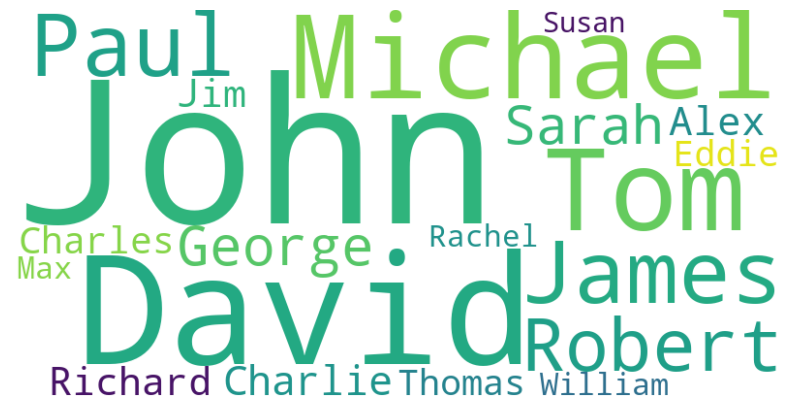

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud from the counts
wordcloud = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=1, collocations=False).generate_from_frequencies(count_top_names)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 5) N-gram Analysis

## 5.a) Clustering and dimentionality reduction

In [ ]:

phonetic_df['Phonetic'] = phonetic_df['Character_name'].apply(lambda x: doublemetaphone(x)[0])
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
char_ngrams = vectorizer.fit_transform(phonetic_df['Character_name'])



In [ ]:
# We create a Dataframe with the n-gram features
ngram_df = pd.DataFrame(char_ngrams.toarray(), columns=vectorizer.get_feature_names_out())
ngram_df = ngram_df.astype('float32') # converting to float32 to decrease the computing time

ngram_df.shape # We see that the dimentionality of ngram is very high, potentially increasing exponentially the processing time, we will deal with that later

(139927, 10394)

In [ ]:
# We use minibatch kmeans clustering becease is more efficient for larger datasets
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=1000, random_state=42) 
phonetic_df['cluster'] = kmeans.fit_predict(ngram_df)


Le code juste en dessous prend 5 min a run


In [ ]:
# PREND 5 min A RUN

# To reduce n-gram dimentionality we use PCA
ipca = IncrementalPCA(n_components=3, batch_size=500)
pca_result = ipca.fit_transform(ngram_df)




In [ ]:
loadings = pd.DataFrame(ipca.components_.T, columns=[f'PC{i+1}' for i in range(ipca.n_components_)], index=ngram_df.columns)

loadings['PC1']=loadings['PC1'].apply(abs)

print(loadings['PC1'].nlargest(10))

an     0.827834
ha     0.194223
nd     0.155080
and    0.150202
ra     0.136661
han    0.125958
ma     0.121196
er     0.120712
na     0.109419
man    0.098447
Name: PC1, dtype: float64


En gros le n-gram decisif qui permet de séparer le plus les noms en clusters c'est "an" (et de loin). 
J'ai aucune idée de comment interpreter ca ???

## 5.b) N-gram pour les pays

In [ ]:
df_country = phonetic_df.copy()
df_country['pca_one'] = pca_result[:, 0]
df_country['pca_two'] = pca_result[:, 1]
df_country['pca_three'] = pca_result[:, 2]

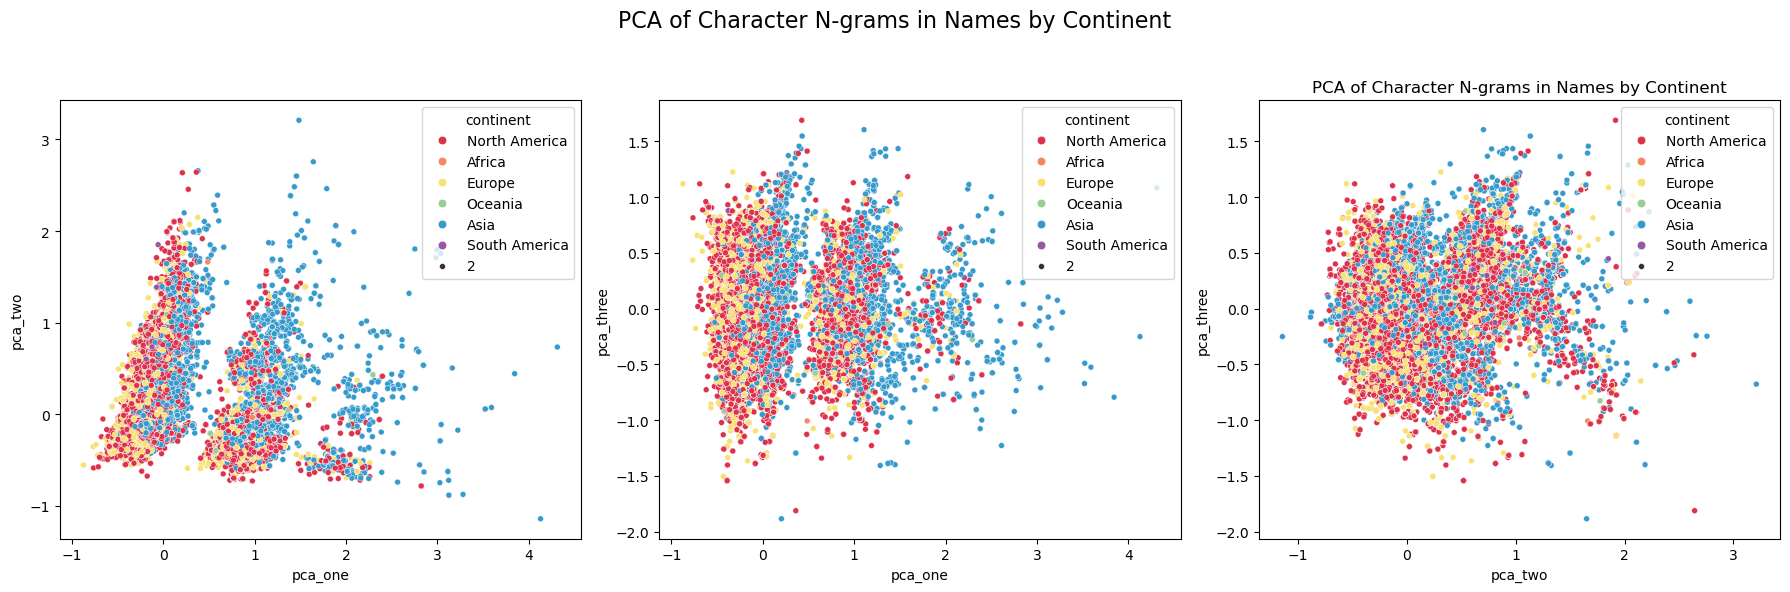

In [ ]:



# Visualization
palette = ['#de324c','#f4895f','#f8e16f','#95cf92','#369acc','#9656a2']
fig,axs = plt.subplots(1,3,figsize=(18, 6))
fig.suptitle("PCA of Character N-grams in Names by Continent", fontsize=16)

sns.scatterplot(x="pca_one", y="pca_two", hue="continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[0])
sns.scatterplot(x="pca_one", y="pca_three", hue="continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[1])
sns.scatterplot(x="pca_two", y="pca_three", hue="continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[2])
plt.title("PCA of Character N-grams in Names by Continent")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Même si y'a pas de claire division entre les continents on voit que l'Asie a des noms avec des n-grams un peu different par rapport aux autres continent

## 5.c) Ngram for genres

In [ ]:
df_genre = phonetic_df.copy()
df_genre['pca_one'] = pca_result[:, 0]
df_genre['pca_two'] = pca_result[:, 1]

In [ ]:
top_genres=df_genre['Genres'].explode().value_counts().head(11)
print(top_genres)

Genres
Drama               79733
Comedy              41292
Romance Film        29959
Thriller            28778
Action              24325
Crime Fiction       19257
World cinema        16592
Adventure           15093
Action/Adventure    13616
Indie               12804
Family Film         11356
Name: count, dtype: int64


In [ ]:
def top_genre_search(genres:list[str]):
    for genre in genres:
        if genre in top_genres:
            return genre         
    return 'other'
        
df_genre['top_genre'] = df_genre['Genres'].apply(top_genre_search)


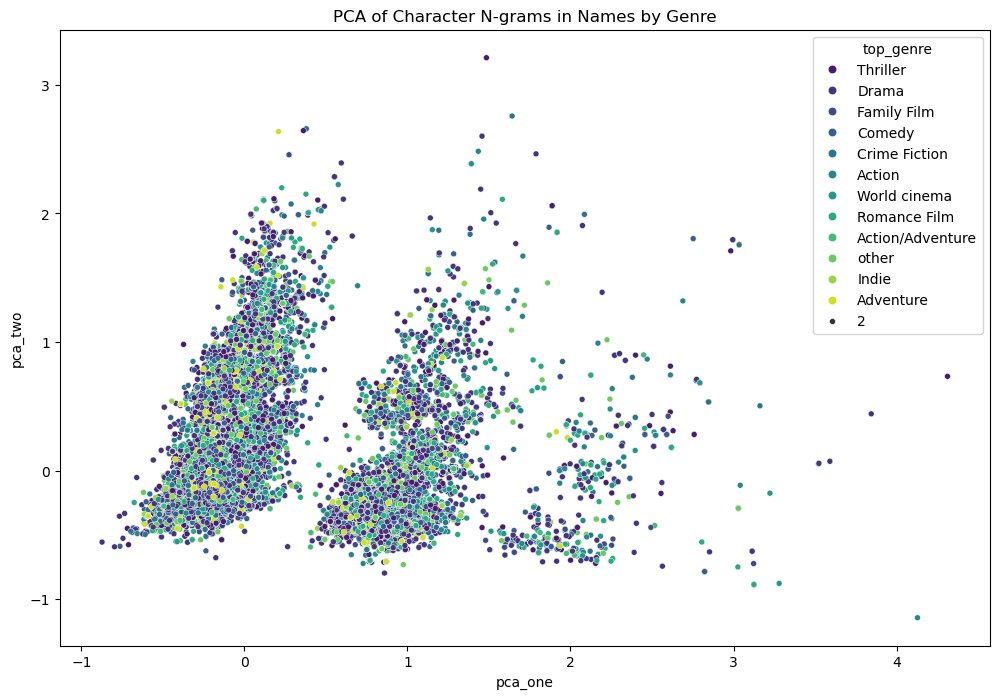

In [ ]:

plt.figure(figsize=(12, 8))
sns.scatterplot(x="pca_one", y="pca_two", hue="top_genre", data=df_genre, palette="viridis", size=2,linewidth=0.3)
plt.title("PCA of Character N-grams in Names by Genre")
plt.show()

Tout est mélangé 

## Sentimental Analysis

### 1. Preproccessing Movie Synopses

In [ ]:
plot_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', names=['Wikipedia_ID', 'Synopses'])

plot_summaries = pd.merge(kept_names, plot_summaries, on='Wikipedia_ID', how='inner')
plot_summaries.head()

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,...,?,??,vowel_count,consonant_count,name_length,vowel_percentage,consonant_percentage,first_letter,last_letter,Synopses
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,/m/0bgcj3x,/m/03wcfv7,5,3,8,0.625000,0.375000,a,y,"Set in the second half of the 22nd century, th..."
1,975900,/m/03vyhn,2001-08-24,Melanie,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,/m/0bgchn4,/m/0346l4,4,3,7,0.571429,0.428571,m,e,"Set in the second half of the 22nd century, th..."
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,/m/0bgchn_,/m/01vw26l,3,5,8,0.375000,0.625000,w,s,"Set in the second half of the 22nd century, th..."
3,975900,/m/03vyhn,2001-08-24,Sgt,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,/m/0bgchnq,/m/034hyc,0,3,3,0.000000,1.000000,s,t,"Set in the second half of the 22nd century, th..."
4,975900,/m/03vyhn,2001-08-24,Bashira,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,/m/0bgchp9,/m/01y9xg,3,4,7,0.428571,0.571429,b,a,"Set in the second half of the 22nd century, th..."


### 2. Clean the Synopses

#### 2.1 Link Pronouns to Nouns

In [ ]:
import spacy
nlp = spacy.load("en_core_web_trf")

pronouns = ["he", "she", "they", "him", "her", "his", "hers", "them"]

def map_pronouns_to_characters(sentence, characters, pronouns):
    doc = nlp(sentence)
    pronoun_mapping = {}
    named_entities = set([ent.text for ent in doc.ents])
    characters = [char.lower() for char in characters]

    antecedent = ""

    for token in doc:
        if token.text.lower() in pronouns:
            if token.dep_ in ("nsubj", "nsubjpass"):
                    antecedent = token.text
            elif token.dep_ == "dobj" and token.head.dep_ == "ccomp":
                antecedent = token.head.head.text

        if antecedent and antecedent.lower() in characters or antecedent.lower() in named_entities:
            if antecedent.lower() in characters or antecedent.lower() in named_entities:
                pronoun_mapping[token.text] = antecedent
        antecedent = ""

    return pronoun_mapping

sentence1 = "John and Sarah went to the park. She had a great time. The Doctor helped with the investigation."
character1 = ["John", "Sarah"]

test = map_pronouns_to_characters(sentence1, character1, pronouns)
print(test)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.6 MB/s eta 0:00:0000:0100:08
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


ValueError: [E002] Can't find factory for 'curated_transformer' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).

Available factories: attribute_ruler, tok2vec, merge_noun_chunks, merge_entities, merge_subtokens, token_splitter, doc_cleaner, parser, beam_parser, lemmatizer, trainable_lemmatizer, entity_linker, entity_ruler, tagger, morphologizer, ner, beam_ner, senter, sentencizer, spancat, spancat_singlelabel, span_finder, future_entity_ruler, span_ruler, textcat, textcat_multilabel, en.lemmatizer